In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
url = "https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv"
df = pd.read_csv(url).drop(columns=['Unnamed: 32'])
print(df.shape)
df.head()

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [41]:
df.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [0]:
def pca_function(df, threshold, show_scree_plot=True, 
                 scaled=False, excluded_cols=None):
  '''
  Takes a pandas dataframe and a desired threshold, scales the numeric features 
  and performs principal component analysis dimension reduction, and returns
  a pandas dataframe of lower dimensionality and variance explained to the given
  threshold
    
  Parameters
  ----------
  df : pandas dataframe
      The dataframe containing data to perform PCA on
      
  threshold : The desired % of variance explained to be included in the return;
              must be an number between 0 and 100
  
  show_scree_plot : Bool indicating whether or not to display scree plot showing 
                    the % variance explained by each principal component; 
                    default set to True
  
  scaled : Bool indicating whether the numeric data has been scaled; default set 
           to False
  
  exclude_cols : list of numeric columns to exclude from PCA; default set to None

  Returns
  -------
  dataframe:
      a pandas dataframe where the numeric columns have been scaled and 
      dimensions reduced to the number of principal components which explain
      the variance at a given threshold
  '''
  
  #confirm proper threshold input:
  if threshold < 0 or threshold > 100:
    return 'Incorrect threshold input, must be a number between 0 and 100'
  
  #library imports
  from sklearn.decomposition import PCA 
  from sklearn.preprocessing import StandardScaler 
  import seaborn as sns
  
  X = df.copy()
  
  if excluded_cols != None:
    X = X.drop(columns=excluded_cols)
    
  #use only the numeric columns that have not been excluded
  numeric_cols = X.select_dtypes(include='number').columns.tolist()
  X = X[numeric_cols].values
  
  if scaled == False:
    #scale the data:
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X)
  else:
    scaled_X = X
    
  #calc the principal component variance
  n = len(numeric_cols)
  covar_matrix = PCA(n_components = n)
  covar_matrix.fit(scaled_X)
  
  ##calculate variance ratios
  variance = covar_matrix.explained_variance_ratio_
  cumulative_var = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
     
  #function for calculating number of principal components to use:
  def calc_num_components(cum_var, threshold):
    for i in range(n):
      if cum_var[i] >= threshold:
        return i+1
  
  #call the function to calulate num_components:
  n_components = calc_num_components(cumulative_var, threshold)
  
  # create the PCA instance
  pca = PCA(n_components = n_components)
  principal_components = pca.fit_transform(scaled_X)

  #scree plot function
  '''
  colors = ['red' if x == n_components else 'grey' for x in X_vals]
  sb.barplot(x=idx, y=values, palette=colors)'''

  def make_scree(cumulative_variance, threshold):
    import matplotlib.pyplot as plt
    import seaborn as sns
  
    n = len(cumulative_variance)
    y_vals = [num for num in cumulative_variance]
    x_vals = [num for num in range(1,n+1)]
    
    colors = ['red' if x == n_components else '#769ddb' for x in x_vals]
    width = min(n/3, 20)
    height = min(n/4, 16)
    fig, ax = plt.subplots(figsize=(width,height))
    ax.grid(True)
    ax.set_title('Principal Components Cumulative Variance')
    ax.set_ylabel('Cumulative Variance % Explained')
    ax.set_xlabel('Principal Components')
  
    # threshold var
    ax.axhline(threshold, color='black', linewidth=1);
    sns.barplot(x=x_vals, y=y_vals, ax=ax, palette=colors)
    plt.show()
  
  if show_scree_plot:
    #plot it:
    make_scree(cumulative_var, threshold)
 
  #convert to pandas df:
  pc_df = pd.DataFrame(data = principal_components, 
                       columns = ['component_' + str(i) for i in range(1, n_components+1)])
  
  #return df which is original df w/ the numeric cols dropped and replaced w/
  #principal components df
  
  df = pd.concat([df, pc_df], axis=1).drop(columns = numeric_cols)
  return df

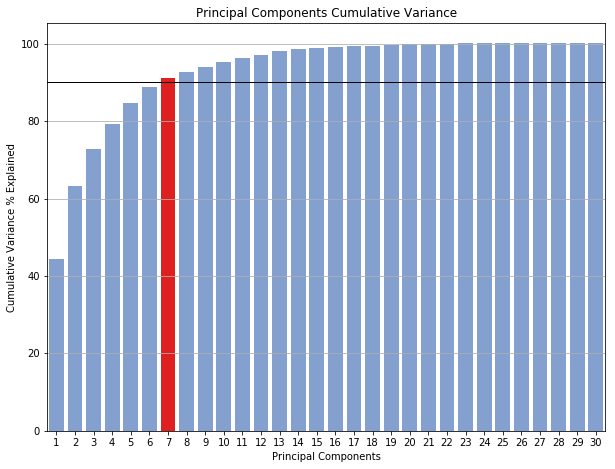

In [43]:
pca_df = pca_function(df, 90, show_scree_plot=True, excluded_cols=['id'])

In [44]:
print(pca_df.shape)
pca_df.head()

(569, 9)


,id,diagnosis,component_1,component_2,component_3,component_4,component_5,component_6,component_7
0,842302,M,9.192837,1.948583,-1.123166,3.633732,-1.195108,1.411435,2.159317
1,842517,M,2.387802,-3.768172,-0.529293,1.118263,0.621774,0.028651,0.013379
2,84300903,M,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541454,-0.668177
3,84348301,M,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053421,1.429915
4,84358402,M,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226500,-0.936181
